In [1]:
# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StringIndexer,OneHotEncoder
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Start a SparkSessions
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 Linear Regression")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

24/08/26 02:31:44 WARN Utils: Your hostname, DESKTOP-H6V94HM resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eth0)
24/08/26 02:31:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/26 02:31:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---

# Functions

In [3]:
def aggregate_data(data, df_type):
    if df_type == "pyspark":
        data = data.groupBy('PULocationID','season', 'month', "avg_temp",
                "avg_windspeed", "avg_dew", "avg_pressure", 'unemp_rate')\
                .agg(
                    F.mean('log_amount').alias('avg_log_amount'),
                    F.mean('log_duration').alias('avg_log_duration'),
                    F.mean('log_distance').alias('avg_log_distance'),
                    F.count('PULocationID').alias('num_trips')
                )
    elif df_type == "pandas":
        data = data \
            .groupby(['PULocationID','season', 'month', "avg_temp",
                    "avg_windspeed", "avg_dew", "avg_pressure", 'unemp_rate']) \
            .agg({
                'log_amount': 'mean',
                'PULocationID': 'count',
                'log_duration': 'mean',
                'log_distance': 'mean'
            })\
            .rename({
                'log_amount': 'avg_log_amount',
                'PULocationID': 'num_trips',
                'log_duration': 'avg_log_duration',
                'log_distance': 'avg_log_distance'
            }, axis = 1)\
            .reset_index()
    return data

def stratified_sampling(data):
    strat_df = data.withColumn("key", F.concat_ws("_", data['PULocationID'], 
                                 data['season'], data['month']))

    group_count  = strat_df.groupBy("key").count()
    group_count = group_count.select("key", "count").distinct().rdd\
        .map(lambda x: (x[0], x[1])).collectAsMap()

    fractions = {key: 1
                if group_count[key] < 100 else 0.2
                for key in group_count}

    # Get the sample
    sample = strat_df.sampleBy("key", fractions=fractions, seed = 42)
    sample = sample.drop("key")

    return sample

def plot_subplot(axs, data, x_col, y_col, row, col):
    axis_dictionary = {
        "avg_log_amount": "Average of log-amount", "avg_temp": "Average air temperature (C)", "avg_dew": "Average dewpoint temperature",
        "avg_pressure": "Average atmospheric pressure (Hectopascals)", "unemp_rate": "Unemployment rate (%)", "PULocationID": "Pickup location",
        "season": "Season", "month": "Month", "avg_windspeed": "Average windspeed (m/s)", "num_trips": "Number of trips recorded"

    }


    axs[row][col].scatter(x = data[x_col], y = data[y_col], edgecolor='black')
    axs[row][col].set_title(f'Scatter plot of {axis_dictionary[y_col]} vs {axis_dictionary[x_col]}')
    axs[row][col].set_xlabel(f'{axis_dictionary[x_col]}')
    axs[row][col].set_ylabel(f'{axis_dictionary[y_col]}')

    return axs

def assemble_data(data):
    location_vector = OneHotEncoder(inputCol="PULocationID", outputCol="location_vec")
    season_indexer = StringIndexer(inputCol="season", outputCol="season_index")
    month_indexer = StringIndexer(inputCol="month", outputCol="month_index")

    #  Separating our predictors and reponse
    predictors = ["location_vec", "season_index", "month_index", "avg_temp", "avg_windspeed",
                    "avg_dew", "avg_pressure", "unemp_rate", "avg_log_amount"]

    response = "num_trips"

    # Assembling the features into a column
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    pipeline = Pipeline(stages=[location_vector, season_indexer, month_indexer, assembler])
    assembled_data = pipeline.fit(data).transform(data)

    return assembled_data

# Generalised Linear Model

## Relationship between response variable and predictors

To explain why we use Generalised Linear Model, let's first plot the response variable against some of the predictors. For this, we will use the `sample.csv` as it sufficient in representing the whole dataset. Also, it's can be read as a pandas dataframe which make it easier for visualisation.

In [4]:
sample = pd.read_csv("../data/curated/sample.csv")
sample = aggregate_data(sample, "pandas")

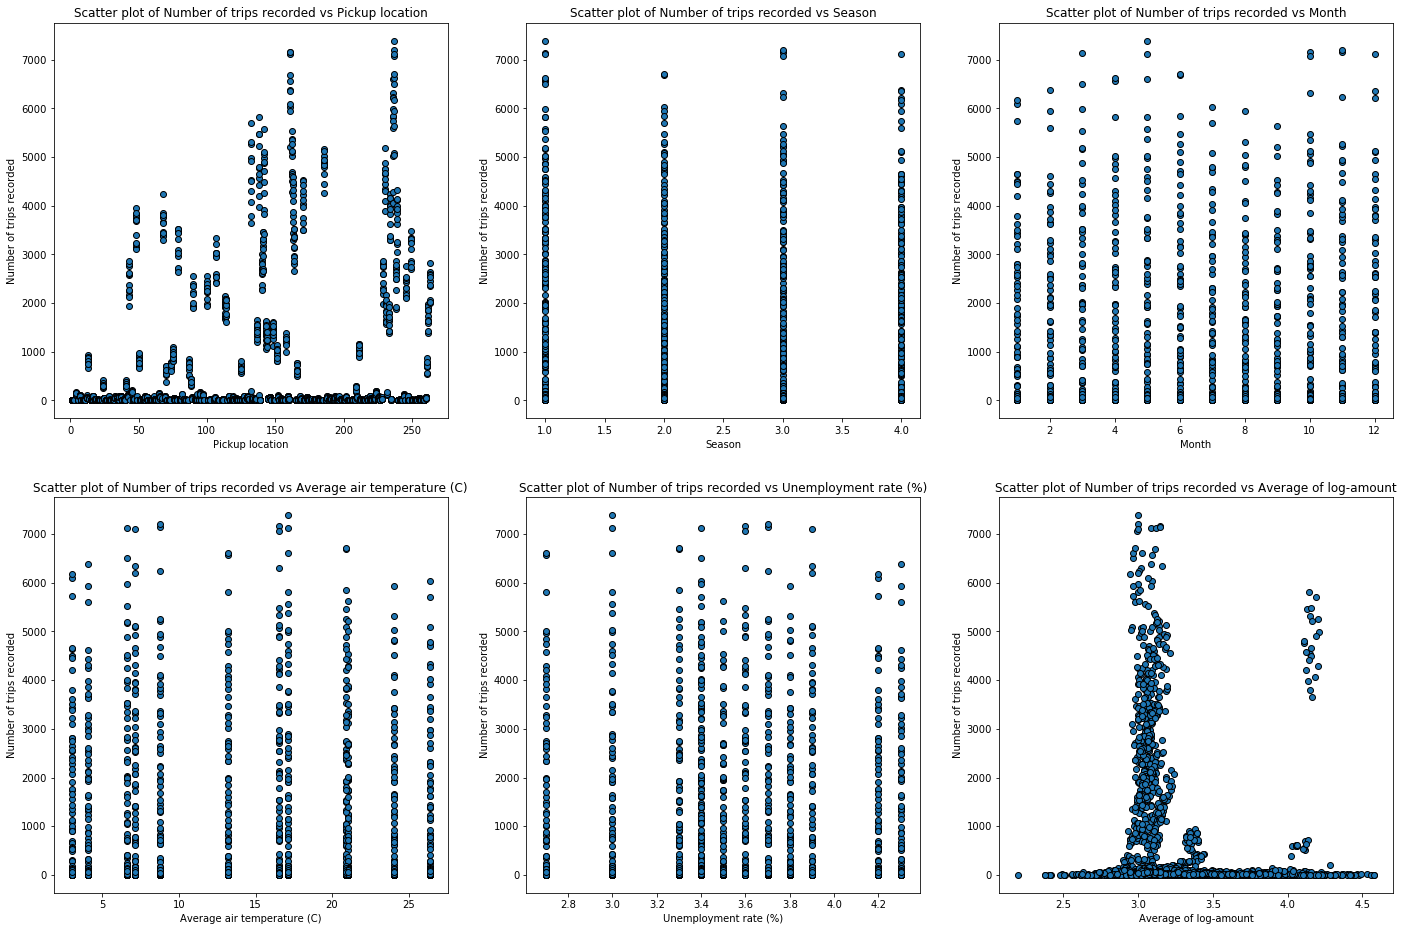

In [5]:
ncols = 3
nrows = 2
fig, axs = plt.subplots(ncols= ncols, nrows = nrows, figsize=(24,16))
y  = 'num_trips'
x = ["PULocationID", "season", "month", "avg_temp", "unemp_rate", "avg_log_amount"]

for r in range(0, nrows):
    # Adjustment term to properly index the list 
    adjust = 0 if r == 0 else 3
    for c in range(0 + adjust, ncols + adjust):
        axs = plot_subplot(axs=axs, data=sample, x_col = x[c], y_col=y, row = r, col = c - adjust)
plt.show()

From all the plots, we can see the data points form into some sort of "pillars". This might be due to the way that we aggregate our data and since we reduce the granularity of the data to months, the number of unique values decreasess. In other words, as we compute the average for some of the continuous numerical features when grouping the data into months, we essentially trade off some of the rows, thus leading to less numerical value in numerical features.

We to use Generalised Linear Model (GLM) as the base line to compare it with our other model, Random Forest Regression (RFR). Though, we think that the GLM model will have a decent prediction rate since our response variable, `num_trips`, is of integer type. Thus, we can use a Poisson to model this relationship. We will assume that there is no interactions between the levels of the factors

## Modelling

For now, we will start of with a simple model, assuming no interactions between the predictors

In [6]:
# Aggregate the data into the desired format
data = spark.read.parquet("../data/curated/trip_records_train")

data = aggregate_data(data, "pyspark")

We can use the same process of handling our categorical variables, preserving their order. Except for `PULocationID`, we will convert them into a binary columns as they have no ordinal meaning

In [7]:
assembled_data = assemble_data(data)

# Split data into train and validation set
train_data, validation_data = assembled_data.randomSplit([0.8, 0.2], seed=123)

In [8]:
# Create our GLM model and fit the training data
glm = GeneralizedLinearRegression(featuresCol="features", labelCol="num_trips", family="poisson", link="log")

model = glm.fit(train_data)

# Fit the validation data and evaluate its performance
predictions = model.transform(validation_data)

evaluator = RegressionEvaluator(labelCol="num_trips", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"Root Mean Squared Error (RMSE) on Validation Data: {rmse}")
print(f"R2 (Coefficient of Determination) on Validation Data: {r2}")

Root Mean Squared Error (RMSE) on Validation Data: 4112.771560748865
R2 (Coefficient of Determination) on Validation Data: 0.9743531855980686


Let's test the model on our both test data and its sample

In [9]:
# Read the full data and sample it
test_data = spark.read.parquet("../data/curated/trip_records_test")

# Aggregate the data
test_data = aggregate_data(test_data, "pyspark")

In [10]:
# Assemble the test data and the sample
assem_test_data = assemble_data(test_data)

In [11]:
test_predictions = model.transform(assem_test_data) 
rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse}")
print(f"R2 (Coefficient of Determination) on Test Data: {r2}")

Root Mean Squared Error (RMSE) on Test Data: 2935.2145492178233
R2 (Coefficient of Determination) on Test Data: 0.9878953086810643


In [12]:
from pyspark.sql.types import IntegerType
agg_prediction = test_predictions.groupBy("month").agg(
    F.sum(F.col("num_trips")).alias("actual_total_trips"),
    F.round(F.sum(F.col("prediction"))).cast(IntegerType()).alias("glm_predicted_total_trips")
)

In [ ]:
agg_prediction.write.parquet("../data/curated/glm_prediction")